In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_single_file":True, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False,
          "Load_data":True,
          "FLATTEN":False, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False,
          "Load_lepton_signal":True,
          "Load_pi0_signal":False}

Params, samples = Functions.create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run1 samples: 
['overlay']


In [3]:
samples_dict = {}

for sample in samples:
    if sample in Constants.Detector_variations:
        file = pd.read_pickle(loc_pkls+"DetVars/overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
        samples_dict[sample] = file
    if Params["Load_Signal_DetVars"] == True:
        file = pd.read_pickle(loc_pkls+"Signal_DetVars/"+Params["Run"]+f"_{sample}_"+Params["Reduced_state"]+".pkl")
        samples_dict[sample] = file
    else:
        if sample == 'signal':
            for HNL_mass in Constants.HNL_mass_samples:
                file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[HNL_mass] = file
        elif sample == 'pi0_signal':
            for HNL_mass in Constants.HNL_mass_pi0_samples:
                file = pd.read_pickle(loc_pkls+f"{sample}_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[str(HNL_mass)+"_pi0"] = file
        elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
            HNL_mass = sample
            file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
            samples_dict[HNL_mass] = file
        else: 
            file = pd.read_pickle(loc_pkls+f"{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
            samples_dict[sample] = file

print(samples_dict.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'pkl_files/run1/current_files/my_vars/overlay_run1_my_vars_unflattened_New_gen.pkl'

In [4]:
def Apply_swtrig(df):
    query="swtrig_pre>0"
    df.query(query)

def Apply_flash_shift(df, sample_type):
    #Only required for beam off, overlay, dirtoverlay and signal (i.e all except beamon data)
    if(sample_type=="beamoff"): df["flash_time"]=df["flash_time"] -0.359
    else: df["flash_time"]=df["flash_time"] - 0.304
    
Pre_swtrig_dict = {}
swtrig = {}
apply_swtrig = True

for sample in samples_dict:
    Pre_swtrig_dict[sample] = len(samples_dict[sample]) #Should weight this properly, i.e take sum of weights for the total number.
    if(apply_swtrig):
        swtrig[sample] = samples_dict[sample].query("swtrig_pre>0")
    if sample != "beamgood":
        Apply_flash_shift(samples_dict[sample], sample)
        
cut_dict = Constants.Preselection_dict_for_plot
        
samples_dict["overlay"]=samples_dict["overlay"].query(cut_dict['nslice'])
print("Made nslice cut")

Made nslice cut


## Calculate systematic error

In [5]:
#Calculate sys
variable = 'nu_flashmatch_score'

# Norm = sample_norms["overlay"]
if Params["Run"] == "run1":Norm = Constants.SF_overlay_run1
if Params["Run"] == "run3":Norm = Constants.SF_overlay_run3

xlims = [0,40]
nbins = 20
BINS = np.linspace(xlims[0],xlims[1], nbins)


In [6]:
results_dict_ppfx=Functions.All_reweight_err(samples_dict["overlay"],"weightsPPFX",variable,BINS,xlims,Norm)

print(f"Calculated ppfx uncertainty")

Calculated ppfx uncertainty


In [7]:
results_dict_genie=Functions.All_reweight_err(samples_dict["overlay"],"weightsGenie",variable,BINS,xlims,Norm)

print(f"Calculated genie uncertainty")

Calculated genie uncertainty


In [8]:
cov_ppfx = results_dict_ppfx["weightsPPFX"][0]
cov_genie = results_dict_genie["weightsGenie"][0]
var_Overlay = samples_dict["overlay"][variable]
# print(cov_PPFX)
overlaybkg=np.histogram(var_Overlay,bins=BINS,range=xlims)[0]

weight_Overlay=samples_dict["overlay"]["weight"]*Norm
#weighted hists
overlaybkg_weighted=np.histogram(var_Overlay,bins=BINS,range=xlims,weights=weight_Overlay)[0]

mc_w=np.histogram(var_Overlay,bins=BINS,range=xlims,weights=weight_Overlay**2)

mc_err=np.sqrt(mc_w[0])

# stat_bkgerr=np.sqrt(offbkg_stat**2+overlaybkg_stat**2+dirtbkg_stat**2) #Adding stat errors in quadrature, my way
stat_bkgerr=mc_err #Adding stat errors in quadrature

cov_mc_stat   = np.zeros([len(stat_bkgerr), len(stat_bkgerr)])
cov_mc_stat[np.diag_indices_from(cov_mc_stat)]=stat_bkgerr**2 #Don't actually need here

tot_ppfx_err=np.sqrt(np.diag(cov_ppfx))
tot_genie_err=np.sqrt(np.diag(cov_genie))
tot_mcerr = np.sqrt(np.diag(cov_ppfx+cov_genie))

print(tot_mcerr)
print(stat_bkgerr)

[1625.1613486  2747.9538262  1606.43479441 1061.14297328  758.35099202
  571.24570608  441.10848661  351.82756532  287.89349603  229.52238309
  197.89556957  173.33256147  142.95319747  132.56797277  123.07104854
  106.33265414  102.9291017    94.85917536   94.01912989]
[60.694897 78.353546 57.647823 47.040916 38.71001  33.372425 29.601751
 26.52328  23.714035 20.577644 19.203627 17.683966 16.445934 15.817193
 15.952811 14.199197 13.867044 13.795026 12.903488]


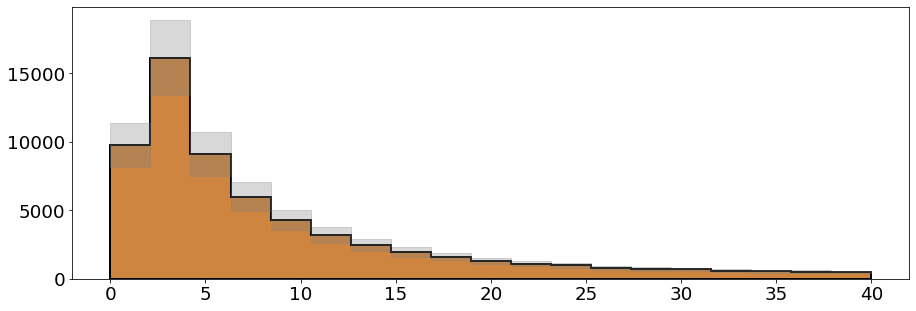

In [9]:
varis=[var_Overlay]
weights=[weight_Overlay]
colors=['peru']
labels=[fr"In-Cryo $\nu$"]

x,y=np.histogram(var_Overlay,bins=BINS,range=xlims,density=False)
x1,y=np.histogram(var_Overlay,bins=BINS,range=xlims)

plot=plt.hist(varis,
          label=labels,
          range=xlims,bins=BINS,
          histtype="stepfilled",
          stacked=True,density=False,linewidth=2,edgecolor="black",
          weights=weights, color=colors)

upvals=np.append((plot[0]+tot_mcerr),(plot[0]+tot_mcerr)[-1])
lowvals=np.append((plot[0]-tot_mcerr),(plot[0]-tot_mcerr)[-1])

plt.fill_between(y, lowvals, upvals,step="post",color="grey",alpha=0.3,zorder=2)

## Check fraction is flat across distribution

[0.16610461 0.17001133 0.17579509 0.17668979 0.17618448 0.17773863
 0.17927453 0.17881179 0.17706818 0.17658221 0.17841741 0.17768302
 0.17809755 0.17958102 0.17926503 0.1764537  0.18415394 0.18019745
 0.189737  ]


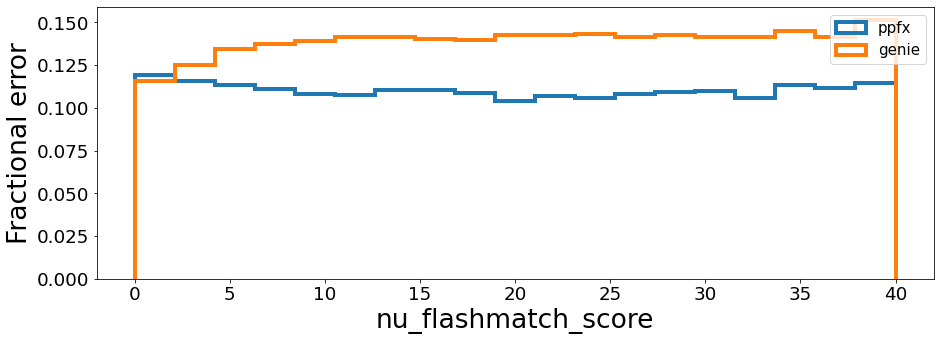

In [10]:
frac = np.divide(tot_mcerr, plot[0])
frac_ppfx = np.divide(tot_ppfx_err, plot[0])
frac_genie = np.divide(tot_genie_err, plot[0])
print(frac)

bins_cent=(BINS[:-1]+BINS[1:])/2
plt.hist(bins_cent,weights=np.nan_to_num(frac_ppfx),bins=BINS,range=xlims,density=False, label="ppfx", histtype="step", lw=4)
plt.hist(bins_cent,weights=np.nan_to_num(frac_genie),bins=BINS,range=xlims,density=False, label="genie",  histtype="step", lw=4)
plt.legend()

plt.xlabel(variable)
plt.ylabel(f"Fractional error")
plt.savefig("plots/Data_MC_comparison/Overlay_sys_unc/" + Params["Run"] + f"_{variable}_ppfx_and_genie_frac_err.png")

In [11]:
#Calculate average
length = len(frac)
total = sum(np.nan_to_num(frac))
total_ppfx = sum(np.nan_to_num(frac_ppfx))
total_genie = sum(np.nan_to_num(frac_genie))

mean = total/length
mean_ppfx = total_ppfx/length 
mean_genie = total_genie/length 

print(Params["Run"])

print(f"mean ppfx is {mean_ppfx}")
print(f"mean genie is {mean_genie}")

run3
mean ppfx is 0.11017149314295216
mean genie is 0.13935860533463815
